Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [3]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [4]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5242, 3081, 12, 6, 195, 2, 3136, 46, 59, 156]


Function to generate a training batch for the skip-gram model.

In [5]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['anarchism', 'as', 'a', 'originated', 'term', 'as', 'a', 'of']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['a', 'originated', 'term', 'anarchism', 'as', 'term', 'originated', 'of']


Train a skip-gram model.

In [6]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [7]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.113319
Nearest to as: telekom, dominos, channeled, saucer, reflux, integrals, bacharach, manchukuo,
Nearest to used: harbor, hymenoptera, dct, anthems, headmaster, tarmac, commemorate, emporia,
Nearest to world: mikoto, fanbase, mil, sapir, waters, museo, nebula, chaparral,
Nearest to only: bsd, rod, lung, true, offenbach, scullin, oncoming, isotope,
Nearest to th: noise, prostate, rampage, fogo, barbarossa, codon, hymn, headland,
Nearest to has: evo, naur, loved, bai, david, machete, invests, son,
Nearest to or: upgrading, degradation, converters, homomorphisms, ingram, emulsions, misskelley, gorilla,
Nearest to not: rigs, cannibalistic, smack, quanta, thee, fluorine, capitalistic, surnames,
Nearest to eight: wrc, exercised, breath, cigars, codebreakers, elric, normalized, adverbs,
Nearest to five: baasha, bloomberg, sour, disperse, performance, yitzchak, proliferated, drilling,
Nearest to may: customary, raven, saviola, turnpike, pubescent, relie

Average loss at step 52000: 3.438526
Average loss at step 54000: 3.430136
Average loss at step 56000: 3.438349
Average loss at step 58000: 3.398938
Average loss at step 60000: 3.396171
Nearest to as: recessions, when, shaivism, lear, metallic, fiendish, xers, unseen,
Nearest to used: known, written, seen, referred, available, designed, described, found,
Nearest to world: appendices, u, stimson, bothnian, laud, jug, cold, sculpture,
Nearest to only: usually, also, journ, not, always, unobstructed, sheol, adornment,
Nearest to th: ad, six, five, ce, nd, bc, eight, four,
Nearest to has: had, have, was, is, having, newbies, although, ayub,
Nearest to or: and, than, but, pepper, languedoc, revitalized, like, demeter,
Nearest to not: usually, still, you, they, always, this, it, to,
Nearest to eight: six, nine, seven, four, five, three, zero, one,
Nearest to five: six, four, three, eight, seven, nine, zero, two,
Nearest to may: can, would, could, will, should, might, must, cannot,
Nearest to 

In [8]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

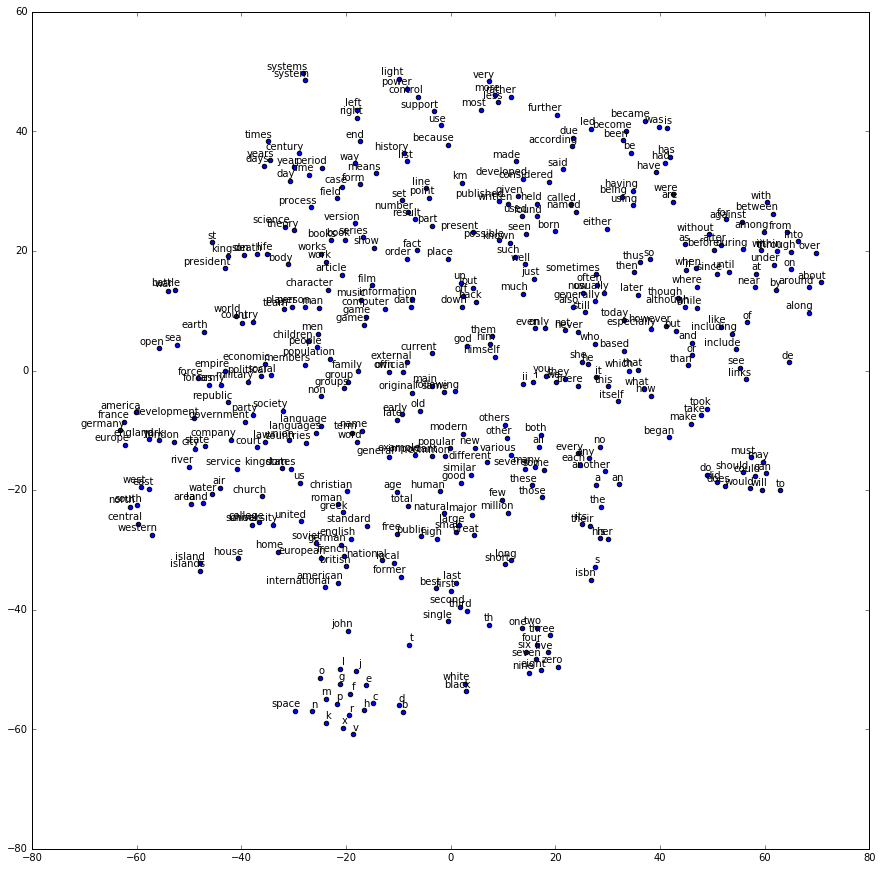

In [9]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

In [6]:
def generate_batch(batch_size, skip_window):
    # skip window is the amount of words we're looking at from each side of a given word
    # creates a single batch
    global data_index
    assert skip_window%2==1
 
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
 
    batch = np.ndarray(shape=(batch_size,span-1), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    # e.g if skip_window = 2 then span = 5
    # span is the length of the whole frame we are considering for a single word (left + word + right)
    # skip_window is the length of one side
 
    # queue which add and pop at the end
    buffer = collections.deque(maxlen=span)
 
    #get words starting from index 0 to span
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
 
    # num_skips => # of times we select a random word within the span?
    # batch_size (8) and num_skips (2) (4 times)
    # batch_size (8) and num_skips (1) (8 times)
    for i in range(batch_size):
        target = skip_window  # target label at the center of the buffer
        target_to_avoid = [ skip_window ] # we only need to know the words around a given word, not the word itself
 
        # do this num_skips (2 times)
        # do this (1 time)
 
        # add selected target to avoid_list for next time
        col_idx = 0
        for j in range(span):
            if j==span//2:
                continue
            # e.g. i=0, j=0 => 0; i=0,j=1 => 1; i=1,j=0 => 2
            batch[i,col_idx] = buffer[j] # [skip_window] => middle element
            col_idx += 1
        labels[i, 0] = buffer[target]
 
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
 
    assert batch.shape[0]==batch_size and batch.shape[1]== span-1
    return batch, labels


In [7]:
if __name__ == '__main__':
    batch_size = 128
    embedding_size = 128 # Dimension of the embedding vector.
    skip_window = 1 # How many words to consider left and right.
    num_skips = 2 # How many times to reuse an input to generate a label.
    valid_size = 16 # Random set of words to evaluate similarity on.
    valid_window = 100 # Only pick dev samples in the head of the distribution.
    # pick 16 samples from 100
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples,random.sample(range(1000,1000+valid_window), valid_size//2))
    num_sampled = 64 # Number of negative examples to sample.
 
    graph = tf.Graph()
 
    with graph.as_default(), tf.device('/cpu:0'):
 
        # Input data.
        train_dataset = tf.placeholder(tf.int32, shape=[batch_size,2*skip_window])
        train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
        valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
 
        # Variables.
        # embedding, vector for each word in the vocabulary
        embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
        softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
        # Model.
        embeds = None
        for i in range(2*skip_window):
            embedding_i = tf.nn.embedding_lookup(embeddings, train_dataset[:,i])
            print('embedding %d shape: %s'%(i,embedding_i.get_shape().as_list()))
            emb_x,emb_y = embedding_i.get_shape().as_list()
            if embeds is None:
                embeds = tf.reshape(embedding_i,[emb_x,emb_y,1])
            else:
                embeds = tf.concat([embeds,tf.reshape(embedding_i,[emb_x,emb_y,1])],2)
                
        assert embeds.get_shape().as_list()[2]==2*skip_window
        print("Concat embedding size: %s"%embeds.get_shape().as_list())
        avg_embed =  tf.reduce_mean(embeds,2,keep_dims=False)
        print("Avg embedding size: %s"%avg_embed.get_shape().as_list())

#         print(avg_embed.dtype)
#         print(softmax_weights.dtype)
#         loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, avg_embed,
#                        train_labels, num_sampled, vocabulary_size))
        loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=avg_embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

        optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
 
        # We use the cosine distance:
        norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
        normalized_embeddings = embeddings / norm
        valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
        similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))



embedding 0 shape: [128, 128]
embedding 1 shape: [128, 128]
Concat embedding size: [128, 128, 2]
Avg embedding size: [128, 128]


In [8]:
num_steps=100001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(batch_size, skip_window)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
                # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Average loss at step 0: 7.561981
Nearest to while: implosion, sexually, adhere, rebelling, carnival, crowded, ejaculate, bards,
Nearest to one: twinning, itinerary, rifles, hyperinsulinism, kyle, lesser, soot, tactician,
Nearest to but: tact, buzz, conforms, netherland, stephane, lighten, solidifies, candela,
Nearest to will: receipts, respiratory, flocks, constantly, rationalization, freenode, authentic, hemiparesis,
Nearest to many: marshallese, anus, tommy, oligarchic, indispensable, senussi, sash, irresistible,
Nearest to and: routes, devo, northwest, chen, barents, qcd, solanaceae, yonkers,
Nearest to use: radically, briefcase, sixths, refuge, amber, biplane, pinyin, marmalade,
Nearest to on: wuppertal, seaton, resented, rest, pungent, ktav, fend, eastwood,
Nearest to operating: bmx, sistine, small, buckwheat, exploring, sutras, duodenum, nave,
Nearest to account: chateau, gath, sulfuric, cuny, h

Average loss at step 46000: 2.903728
Average loss at step 48000: 2.872660
Average loss at step 50000: 2.848213
Nearest to while: although, when, ejaculate, but, were, overbeck, and, including,
Nearest to one: four, two, facet, madhu, saeima, seven, scurvy, psychiatrists,
Nearest to but: however, and, although, kahanamoku, while, unschooling, see, sickle,
Nearest to will: would, can, could, may, must, might, should, cannot,
Nearest to many: some, several, various, numerous, these, most, all, those,
Nearest to and: or, but, isopropanol, ultimate, including, while, than, vampyre,
Nearest to use: neoclassicism, content, carry, hydrophilic, beings, history, scope, presenters,
Nearest to on: upon, through, in, within, under, seaton, at, seekers,
Nearest to operating: numeral, defendants, nervous, sistine, nave, crossed, seq, falsified,
Nearest to account: happiness, sexist, gath, hideous, somaliland, ordering, nephritis, luo,
Nearest to active: operates, posse, kuril, ware, mears, headlined,